In [1]:
# Import required libraries
import math
from itertools import combinations
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import io
from scipy.signal import hilbert
from scipy.fft import fft

from Functions.AR_filter import ar_filter
from Functions.TimeFeature import timefeature
from Functions.Bear_feat import Bear_feat
from Functions.Scatmat import ScattMat
from Functions.Skbp import skbp

In [2]:
## CWRU bearing
plt.rc('font', size=11)
os.chdir('Data_repository/CWRU_bearing')
bff = np.array([3.5848, 5.4152, 0.3983, 4.7135])
cutoff = 3; fr = 1730/60; fs = int(io.loadmat('Normal.mat')['fs'])
# =========================== Load data ===================================
normal = io.loadmat('Normal.mat')['x']
outer = io.loadmat('Outer.mat')['x']
inner = io.loadmat('Inner.mat')['x']

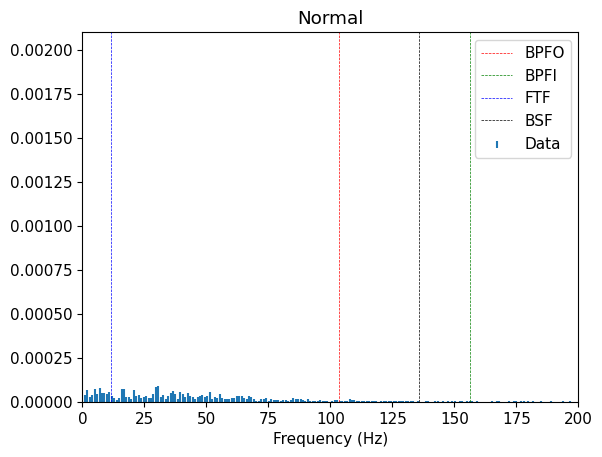

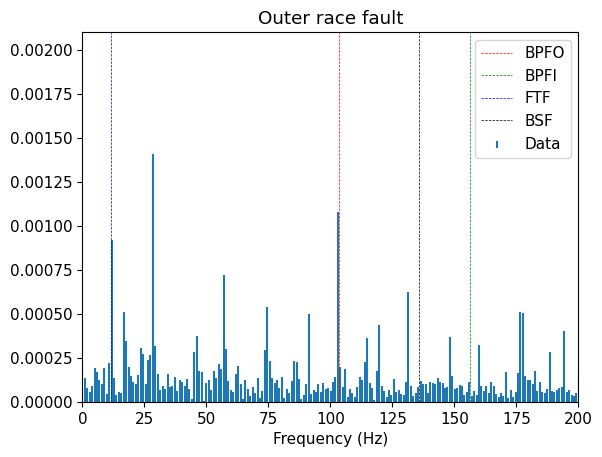

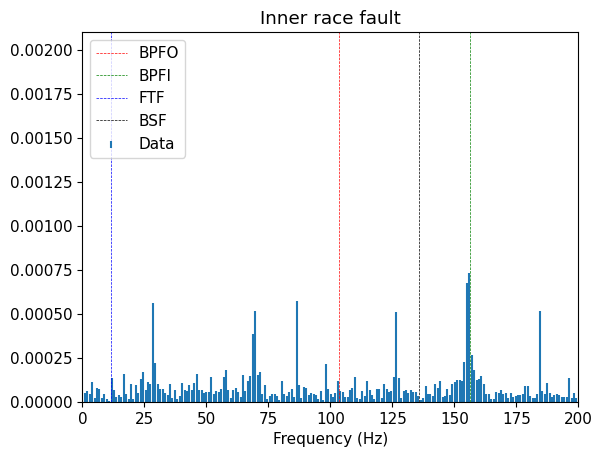

In [3]:
## 1. Signal Processing: AR Filter, SK, Bandpass Filter, Envelope Analysis
x1 = normal[:, 0]; x2 = outer[:, 0]; x3 = inner[:, 0]                                   # Example data for each class
n1 = len(x1); n2 = len(x2); n3 = len(x3)
xr1 = ar_filter(x1, 700)[0]; xr2 = ar_filter(x2, 700)[0]; xr3 = ar_filter(x3, 700)[0]   # AR filtering
xb1 = skbp(xr1, fs, 3); xb2 = skbp(xr2, fs, 3); xb3 = skbp(xr3, fs, 3)                  # SK, bandpass filtering
xn1 = np.abs(hilbert(xb1)); xn2 = np.abs(hilbert(xb2)); xn3 = np.abs(hilbert(xb3))      # Envelope
xn1 = xn1 - np.mean(xn1); xn2 = xn2 - np.mean(xn2); xn3 = xn3 - np.mean(xn3)
X1 = np.abs(fft(xn1))/n1*2; X2 = np.abs(fft(xn2))/n2*2; X3 = np.abs(fft(xn3))/n3*2      # FFT
X1 = X1[0:math.ceil(n1/2)]; X2 = X2[0:math.ceil(n2/2)]; X3 = X3[0:math.ceil(n3/2)]
f1 = np.arange(0,n1)/n1*fs; f2 = np.arange(0,n2)/n2*fs; f3 = np.arange(0,n3)/n3*fs
f1 = f1[0:math.ceil(n1/2)]; f2 = f2[0:math.ceil(n2/2)]; f3 = f3[0:math.ceil(n3/2)]

# Normal bearing
plt.figure(1); plt.stem(f1, X1, markerfmt=" ", basefmt=" "); plt.xlim(0, 200); plt.ylim(0, 2.1e-3)
plt.axvline(bff[0]*fr, c='r', ls='--', linewidth=0.5); plt.axvline(bff[1]*fr, c='g', ls='--', linewidth=0.5)
plt.axvline(bff[2]*fr, c='b', ls='--', linewidth=0.5); plt.axvline(bff[3]*fr, c='k', ls='--', linewidth=0.5)
plt.title('Normal'); plt.xlabel('Frequency (Hz)')
plt.legend(['BPFO','BPFI','FTF','BSF','Data'])

# Outer race fault bearing <Figure 11(b)>
plt.figure(2); plt.stem(f2, X2, markerfmt=" ", basefmt=" "); plt.xlim(0, 200); plt.ylim(0, 2.1e-3)
plt.axvline(bff[0]*fr, c='r', ls='--', linewidth=0.5); plt.axvline(bff[1]*fr, c='g', ls='--', linewidth=0.5)
plt.axvline(bff[2]*fr, c='b', ls='--', linewidth=0.5); plt.axvline(bff[3]*fr, c='k', ls='--', linewidth=0.5)
plt.title('Outer race fault'); plt.xlabel('Frequency (Hz)')
plt.legend(['BPFO','BPFI','FTF','BSF','Data'])

# Inner race fault bearing <Figure 11(c)>
plt.figure(3); plt.stem(f3, X3, markerfmt=" ", basefmt=" "); plt.xlim(0, 200); plt.ylim(0, 2.1e-3)
plt.axvline(bff[0]*fr, c='r', ls='--', linewidth=0.5); plt.axvline(bff[1]*fr, c='g', ls='--', linewidth=0.5)
plt.axvline(bff[2]*fr, c='b', ls='--', linewidth=0.5); plt.axvline(bff[3]*fr, c='k', ls='--', linewidth=0.5)
plt.title('Inner race fault'); plt.xlabel('Frequency (Hz)')
plt.legend(['BPFO', 'BPFI', 'FTF', 'BSF', 'Data'], loc='upper left')
plt.show()

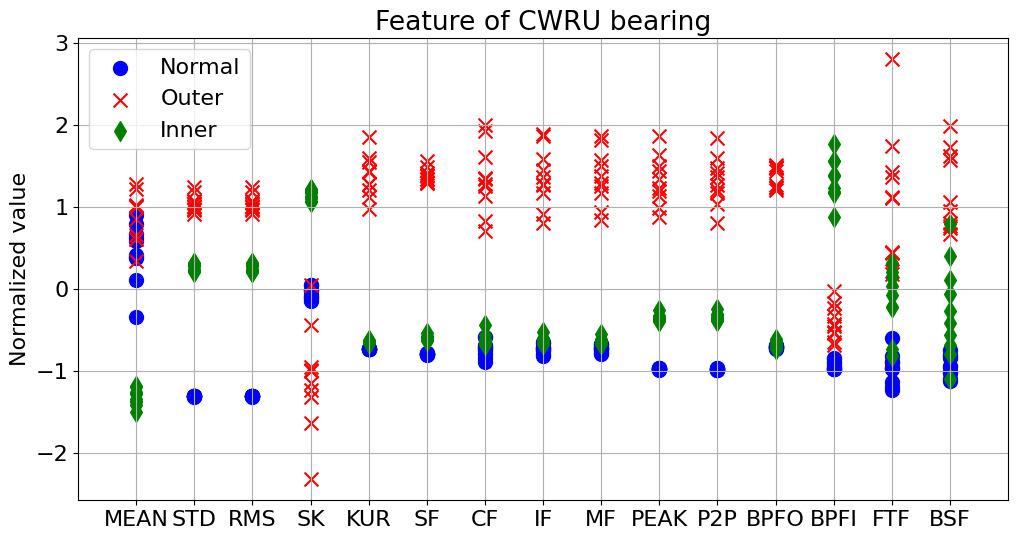

In [4]:
# 2. Feature extraction
# Normal
features_normal = np.zeros((10,15))
for ix in range(10):
    x = normal[:,ix]
    tmp1, fn_time = timefeature(x)
    xr = ar_filter(x, 700)[0]
    tmp2, fn_bearing = Bear_feat(xr, fs, bff*fr, cutoff)
    features_normal[ix, :] = np.hstack([tmp1, tmp2])
# Outer
features_outer = np.zeros((10,15))
for ix in range(10):
    x = outer[:,ix]
    tmp1, fn_time = timefeature(x)
    xr = ar_filter(x, 700)[0]
    tmp2, fn_bearing = Bear_feat(xr, fs, bff*fr, cutoff)
    features_outer[ix, :] = np.hstack([tmp1, tmp2])
# Inner
features_inner = np.zeros((10,15))
for ix in range(10):
    x = inner[:,ix]
    tmp1, fn_time = timefeature(x)
    xr = ar_filter(x, 700)[0]
    tmp2, fn_bearing = Bear_feat(xr, fs, bff*fr, cutoff)
    features_inner[ix, :] = np.hstack([tmp1, tmp2])
feature_name = fn_time + fn_bearing

# Normalizing
features = np.concatenate([features_normal, features_outer, features_inner], axis=0)
m = np.mean(features, axis=0); s = np.std(features, ddof=1, axis=0)
features = (features-m)/s
ix_normal = np.arange(0,10); ix_outer = np.arange(10, 20); ix_inner = np.arange(20,30)

# Features of CWRU bearing <Figrure 12>
plt.rc('font', size=16)
plt.figure(1, figsize=(12, 6))
for ix in range(len(feature_name)):
    plt.scatter(ix * np.ones(10), features[ix_normal, ix], c='b', marker='o', s=100)
    plt.scatter(ix * np.ones(10), features[ix_outer, ix], c='r', marker='x', s=100)
    plt.scatter(ix * np.ones(10), features[ix_inner, ix], c='g', marker='d', s=100)
plt.xticks(range(len(feature_name)), feature_name); plt.xlim(-1, len(feature_name))
plt.legend(['Normal','Outer','Inner'])
plt.title('Feature of CWRU bearing')
plt.ylabel('Normalized value'); plt.grid()
plt.show()

,0,1,2
0,1,2,3
1,"[SK, SF]","[SF, BPFO]","[STD, SF]"
2,751.403882,732.628981,489.563398


,0,1,2
0,1,2,3
1,"[FTF, BSF]","[SK, FTF]","[SK, BSF]"
2,6.636592,10.206722,11.091187


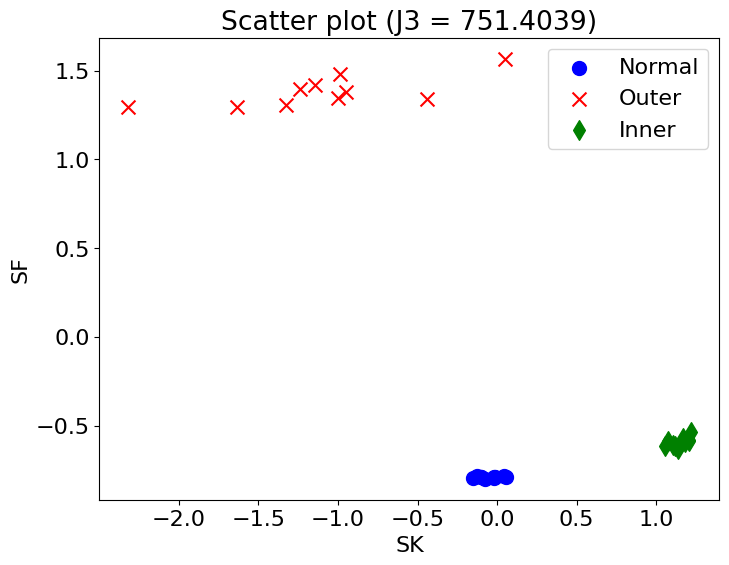

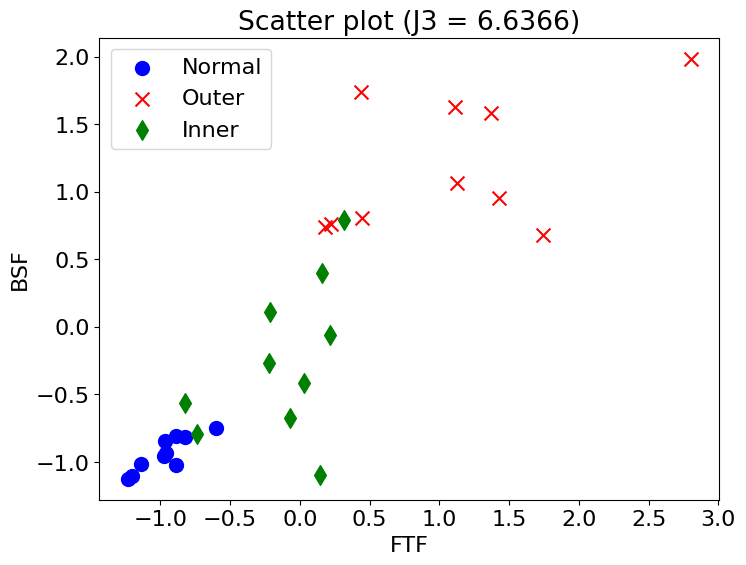

In [5]:
# 3. Feature Selection: Scatter Matrices (J3)
tmp = np.array(list(combinations(np.arange(0, len(feature_name)), 2)))
lab = np.hstack([np.zeros(10), np.ones(10), np.ones(10)*2])
J3 = np.zeros(len(tmp))
for ix in range(len(tmp)):
    J3[ix] = ScattMat(np.c_[features[:, tmp[ix, 0]], features[:, tmp[ix, 1]]],lab)
ix = np.argsort(J3)[::-1]
J3 = J3[ix]

# Best3
Top3 = [1,2,3]
Feature_combination = [[feature_name[tmp[ix[0],0]], feature_name[tmp[ix[0],1]]],
                       [feature_name[tmp[ix[1],0]], feature_name[tmp[ix[1],1]]],
                       [feature_name[tmp[ix[2],0]], feature_name[tmp[ix[2],1]]]]
J3_value = [J3[0], J3[1], J3[2]]
T1 = pd.DataFrame([Top3, Feature_combination, J3_value])
display(T1)

# Worst3
Bottom3 = [1,2,3]
Feature_combination = [[feature_name[tmp[ix[-1],0]], feature_name[tmp[ix[-1],1]]],
                       [feature_name[tmp[ix[-2],0]], feature_name[tmp[ix[-2],1]]],
                       [feature_name[tmp[ix[-3],0]], feature_name[tmp[ix[-3],1]]]]
J3_value = [J3[-1], J3[-2], J3[-3]]
T2 = pd.DataFrame([Bottom3, Feature_combination, J3_value])
display(T2)

# High J3 value
plt.figure(1, figsize=(8, 6))
plt.scatter(features[ix_normal, tmp[ix[0],0]],features[ix_normal, tmp[ix[0],1]], c= 'b', marker='o', s=100)
plt.scatter(features[ix_outer, tmp[ix[0],0]],features[ix_outer, tmp[ix[0],1]], c= 'r', marker='x', s=100)
plt.scatter(features[ix_inner, tmp[ix[0],0]],features[ix_inner, tmp[ix[0],1]], c= 'g', marker='d', s=100)
plt.xlabel(f'{feature_name[tmp[ix[0],0]]}'); plt.ylabel(f'{feature_name[tmp[ix[0],1]]}')
plt.title(f'Scatter plot (J3 = {J3[0]:.4f})')
plt.legend(['Normal','Outer','Inner'])

# Low J3 value
plt.figure(2, figsize=(8, 6))
plt.scatter(features[ix_normal, tmp[ix[-1],0]],features[ix_normal, tmp[ix[-1],1]], c= 'b', marker='o', s=100)
plt.scatter(features[ix_outer, tmp[ix[-1],0]],features[ix_outer, tmp[ix[-1],1]], c= 'r', marker='x', s=100)
plt.scatter(features[ix_inner, tmp[ix[-1],0]],features[ix_inner, tmp[ix[-1],1]], c= 'g', marker='d', s=100)
plt.xlabel(f'{feature_name[tmp[ix[-1],0]]}'); plt.ylabel(f'{feature_name[tmp[ix[-1],1]]}')
plt.title(f'Scatter plot (J3 = {J3[-1]:.4f})')
plt.legend(['Normal','Outer','Inner'])
plt.show()